### Problem 1 (50 points) 

Vapor-liquid equilibria data are correlated using two adjustable parameters $A_{12}$ and $A_{21}$ per binary
mixture. For low pressures, the equilibrium relation can be formulated as:

$$
\begin{aligned}
p = & x_1\exp\left(A_{12}\left(\frac{A_{21}x_2}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{water}^{sat}\\
& + x_2\exp\left(A_{21}\left(\frac{A_{12}x_1}{A_{12}x_1+A_{21}x_2}\right)^2\right)p_{1,4 dioxane}^{sat}.
\end{aligned}
$$

Here the saturation pressures are given by the Antoine equation

$$
\log_{10}(p^{sat}) = a_1 - \frac{a_2}{T + a_3},
$$

where $T = 20$($^{\circ}{\rm C}$) and $a_{1,2,3}$ for a water - 1,4 dioxane
system is given below.

|             | $a_1$     | $a_2$      | $a_3$     |
|:------------|:--------|:---------|:--------|
| Water       | 8.07131 | 1730.63  | 233.426 |
| 1,4 dioxane | 7.43155 | 1554.679 | 240.337 |


The following table lists the measured data. Recall that in a binary system $x_1 + x_2 = 1$.

|$x_1$ | 0.0 | 0.1 | 0.2 | 0.3 | 0.4 | 0.5 | 0.6 | 0.7 | 0.8 | 0.9 | 1.0 |
|:-----|:--------|:---------|:--------|:-----|:-----|:-----|:-----|:-----|:-----|:-----|:-----|
|$p$| 28.1 | 34.4 | 36.7 | 36.9 | 36.8 | 36.7 | 36.5 | 35.4 | 32.9 | 27.7 | 17.5 |

Estimate $A_{12}$ and $A_{21}$ using data from the above table: 

1. Formulate the least square problem; 
2. Since the model is nonlinear, the problem does not have an analytical solution. Therefore, solve it using the gradient descent or Newton's method implemented in HW1; 
3. Compare your optimized model with the data. Does your model fit well with the data?

---

The least square problem can be formulated as follows:

$$
\begin{aligned}
\min_{A_{12},A_{21}}\sum_{i=1}^{11} (p(x_i;A_{12},A_{21})-p_i)^2
\end{aligned}
$$

It can be aptly described as the sum of the errors squared where the error is defined as the difference between the thoeretical model and the experimental data points. This equation is the loss function.

In [16]:
# Here is a code for gradient descent without line search
import math
import torch as t
from torch.autograd import Variable

A = Variable(t.tensor([1.0, 2.0]), requires_grad=True)

# Define constants
c1w = 8.07131
c2w = 1730.63
c3w = 233.426
c1d = 7.43155
c2d = 1554.679
c3d = 240.337

# Calculate pressure of saturated water and dixoane at 20 deg C using Antoine Equation and given constants
psatwater = 10**(c1w - (c2w/(20+c3w)))
psatdioxane = 10**(c1d - (c2d/(20+c3d)))

# Create tensors for x1 and x2
x1 = t.tensor([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
x2 = 1-x1

# Create tensor for p experimental and p theoretical 
pe = t.tensor([28.1, 34.4, 36.7, 36.9, 36.8, 36.7, 36.5, 35.4, 32.9, 27.7, 17.5])
pt = lambda A, x1, x2, psatwater, psatdixoane: x1*t.exp(A[0]*((A[1]*x2)/(A[0]*x1+A[1]*x2))**2)*psatwater + x2*t.exp(A[1]*((A[0]*x1)/(A[0]*x1+A[1]*x2))**2)*psatdioxane 


# Fix the step size
a = 0.001

# Start gradient descent
for i in range(10000):  # TODO: change the termination criterion
    
    loss = t.sum(t.square((pt(A,x1,x2,psatwater,psatdioxane)-pe)))
    loss.backward()
    
    # no_grad() specifies that the operations within this context are not part of the computational graph, i.e., we don't need the gradient descent algorithm itself to be differentiable with respect to x
    with t.no_grad():
        A -= a * A.grad
        
        # need to clear the gradient at every step, or otherwise it will accumulate...
        A.grad.zero_()

print('[A_12 , A_21] = ', A.data.numpy())
print('Loss = ', loss.data.numpy())
print('RSE = ', loss.data.numpy()/3) #Divide loss by square root of number of samples minus degrees of freedom  = sqrt(11 - 2) = 3

[A_12 , A_21] =  [1.9584198 1.6891851]
Loss =  0.67019004
RSE =  0.22339667876561484


Problem 1.3. The residual standard error is 0.223 which means that 68% of the data points fall within 0.223 mmHg of the model. I would consider the model to fit the data pretty well.

### Problem 2 (50 points) 

Solve the following problem using Bayesian Optimization:
$$
    \min_{x_1, x_2} \quad \left(4-2.1x_1^2 + \frac{x_1^4}{3}\right)x_1^2 + x_1x_2 + \left(-4 + 4x_2^2\right)x_2^2,
$$
for $x_1 \in [-3,3]$ and $x_2 \in [-2,2]$. A tutorial on Bayesian Optimization can be found [here](https://thuijskens.github.io/2016/12/29/bayesian-optimisation/).

C:\Users\dmkim\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:509: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


NameError: name 'ax' is not defined

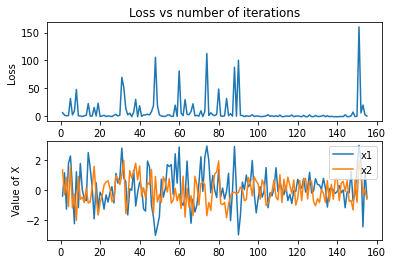

In [21]:
# Code is from:
# https://github.com/thuijskens/bayesian-optimization
""" gp.py

Bayesian optimisation of loss functions.
"""

import numpy as np
import sklearn.gaussian_process as gp

from scipy.stats import norm
from scipy.optimize import minimize

def expected_improvement(x, gaussian_process, evaluated_loss, greater_is_better=False, n_params=1):
    """ expected_improvement

    Expected improvement acquisition function.

    Arguments:
    ----------
        x: array-like, shape = [n_samples, n_hyperparams]
            The point for which the expected improvement needs to be computed.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: Numpy array.
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        n_params: int.
            Dimension of the hyperparameter space.

    """

    x_to_predict = x.reshape(-1, n_params)

    mu, sigma = gaussian_process.predict(x_to_predict, return_std=True)

    if greater_is_better:
        loss_optimum = np.max(evaluated_loss)
    else:
        loss_optimum = np.min(evaluated_loss)

    scaling_factor = (-1) ** (not greater_is_better)

    # In case sigma equals zero
    with np.errstate(divide='ignore'):
        Z = scaling_factor * (mu - loss_optimum) / sigma
        expected_improvement = scaling_factor * (mu - loss_optimum) * norm.cdf(Z) + sigma * norm.pdf(Z)
        expected_improvement[sigma == 0.0] == 0.0

    return -1 * expected_improvement


def sample_next_hyperparameter(acquisition_func, gaussian_process, evaluated_loss, greater_is_better=False,
                               bounds=(0, 10), n_restarts=25):
    """ sample_next_hyperparameter

    Proposes the next hyperparameter to sample the loss function for.

    Arguments:
    ----------
        acquisition_func: function.
            Acquisition function to optimise.
        gaussian_process: GaussianProcessRegressor object.
            Gaussian process trained on previously evaluated hyperparameters.
        evaluated_loss: array-like, shape = [n_obs,]
            Numpy array that contains the values off the loss function for the previously
            evaluated hyperparameters.
        greater_is_better: Boolean.
            Boolean flag that indicates whether the loss function is to be maximised or minimised.
        bounds: Tuple.
            Bounds for the L-BFGS optimiser.
        n_restarts: integer.
            Number of times to run the minimiser with different starting points.

    """
    best_x = None
    best_acquisition_value = 1
    n_params = bounds.shape[0]

    for starting_point in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, n_params)):

        res = minimize(fun=acquisition_func,
                       x0=starting_point.reshape(1, -1),
                       bounds=bounds,
                       method='L-BFGS-B',
                       args=(gaussian_process, evaluated_loss, greater_is_better, n_params))

        if res.fun < best_acquisition_value:
            best_acquisition_value = res.fun
            best_x = res.x

    return best_x


def bayesian_optimisation(n_iters, sample_loss, bounds, x0=None, n_pre_samples=5,
                          gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7):
    """ bayesian_optimisation

    Uses Gaussian Processes to optimise the loss function `sample_loss`.

    Arguments:
    ----------
        n_iters: integer.
            Number of iterations to run the search algorithm.
        sample_loss: function.
            Function to be optimised.
        bounds: array-like, shape = [n_params, 2].
            Lower and upper bounds on the parameters of the function `sample_loss`.
        x0: array-like, shape = [n_pre_samples, n_params].
            Array of initial points to sample the loss function for. If None, randomly
            samples from the loss function.
        n_pre_samples: integer.
            If x0 is None, samples `n_pre_samples` initial points from the loss function.
        gp_params: dictionary.
            Dictionary of parameters to pass on to the underlying Gaussian Process.
        random_search: integer.
            Flag that indicates whether to perform random search or L-BFGS-B optimisation
            over the acquisition function.
        alpha: double.
            Variance of the error term of the GP.
        epsilon: double.
            Precision tolerance for floats.
    """

    x_list = []
    y_list = []

    n_params = bounds.shape[0]

    if x0 is None:
        for params in np.random.uniform(bounds[:, 0], bounds[:, 1], (n_pre_samples, bounds.shape[0])):
            x_list.append(params)
            y_list.append(sample_loss(params))
    else:
        for params in x0:
            x_list.append(params)
            y_list.append(sample_loss(params))

    xp = np.array(x_list)
    yp = np.array(y_list)

    # Create the GP
    if gp_params is not None:
        model = gp.GaussianProcessRegressor(**gp_params)
    else:
        kernel = gp.kernels.Matern()
        model = gp.GaussianProcessRegressor(kernel=kernel,
                                            alpha=alpha,
                                            n_restarts_optimizer=10,
                                            normalize_y=True)

    for n in range(n_iters):

        model.fit(xp, yp)

        # Sample next hyperparameter
        if random_search:
            x_random = np.random.uniform(bounds[:, 0], bounds[:, 1], size=(random_search, n_params))
            ei = -1 * expected_improvement(x_random, model, yp, greater_is_better=True, n_params=n_params)
            next_sample = x_random[np.argmax(ei), :]
        else:
            next_sample = sample_next_hyperparameter(expected_improvement, model, yp, greater_is_better=False, bounds=bounds, n_restarts=100)

        # Duplicates will break the GP. In case of a duplicate, we will randomly sample a next query point.
        if np.any(np.abs(next_sample - xp) <= epsilon):
            next_sample = np.random.uniform(bounds[:, 0], bounds[:, 1], bounds.shape[0])

        # Sample loss for new set of parameters
        cv_score = sample_loss(next_sample)

        # Update lists
        x_list.append(next_sample)
        y_list.append(cv_score)

        # Update xp and yp
        xp = np.array(x_list)
        yp = np.array(y_list)

    return xp, yp

n_iters = 150
n_pre_samples = 5

objFun = lambda x: (4-2.1*x[0]**2+(x[0]**4/3))*x[0]**2+x[0]*x[1]+(-4+4*x[1]**2)*x[1]**2
bounds = np.array([[-3, 3], [-2, 2]])
x, loss = bayesian_optimisation(n_iters, objFun , bounds, x0=None, n_pre_samples=5, gp_params=None, random_search=False, alpha=1e-5, epsilon=1e-7)

import matplotlib.pyplot as plt

# Plot loss vs number of iterations
ax1 = plt.subplot(211) 
plt.plot(np.linspace(1,(n_iters+n_pre_samples),(n_iters+n_pre_samples)), loss)
plt.title('Loss vs number of iterations')
plt.xlabel('Number of iterations')
plt.ylabel('Loss')

# Plot x1 and x2 vs number of iterations
ax2 = plt.subplot(212)
matplot.plot(np.linspace(1,(n_iters+n_pre_samples),(n_iters+n_pre_samples)), x)
plt.ylabel('Value of X')
plt.legend(["x1", "x2"], loc ="upper right")
  

# Print last iterated value of x1 and x2  
print('Optimal x1 = ', x[-1,0])
print('Optimal x2 = ', x[-1,1])
print('Optimal loss = ', loss[-1])

The loss function eventually converges to a value close to 0. The x1 and x2 seem to not converge at a single value. This can indicate that there are multiple solutions that yield equally small losses. However, taking the results of the last iteration, we find one solution to be x1 = 0.244 and x2 = -.08346 which yields a loss of -0.818.